In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [86]:
import warnings
warnings.filterwarnings('ignore')

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

In [87]:
train_folder = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
1,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
2,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
3,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
4,N,/kaggle/input/asl-alphabet/asl_alphabet_train/...
...,...,...
86995,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86996,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86997,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...
86998,J,/kaggle/input/asl-alphabet/asl_alphabet_train/...


In [88]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
print(x_train.shape,x_holdout.shape)
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])
print(x_train.shape,x_test.shape)

(78300, 2) (8700, 2)
(62640, 2) (15660, 2)


In [89]:
# Class imbalance identification
classes = os.listdir(train_folder)
print(classes)

['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


In [90]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.3, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True,
                             
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             fill_mode='nearest')

# train_gen = datagen.flow_from_directory(train_path, subset='training')
# val_gen = datagen.flow_from_directory(train_path, subset='validation')

train_gen = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

val_gen = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False   
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)


Found 62640 validated image filenames belonging to 29 classes.
Found 15660 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [16]:
# Defining the model
import time
start_time1 = time.time()
def get_model1():
    base_model1 = ResNet50V2(include_top=False, input_shape=(200,200,3))
    
    for layer in base_model1.layers[:150]:
        layer.trainable = False
    for layer in base_model1.layers[150:]:
        layer.trainable = True
    
    x = base_model1.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred1 = Dense(len(classes), activation='softmax')(x)
    
    model1 = Model(inputs=base_model1.input, outputs=pred1)
    
    return model1

In [17]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [18]:
# Initiating the model
model1 = get_model1()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [20]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.1
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [21]:
# Training and validating the model
history = model1.fit(train_gen, epochs=40, batch_size=100, validation_data=val_gen,steps_per_epoch=100,validation_steps=50,callbacks=[callback],validation_split = 0.30, 
                    shuffle = True)

Epoch 1/40
100/100 [==============================] - 67s 588ms/step - loss: 1.9020 - tp: 3705.0000 - fp: 1293.0000 - tn: 354867.0000 - fn: 9015.0000 - accuracy: 0.9721 - precision: 0.7413 - recall: 0.2913 - auc: 0.9113 - prc: 0.4917 - val_loss: 3.3209 - val_tp: 2806.0000 - val_fp: 2446.0000 - val_tn: 176754.0000 - val_fn: 3594.0000 - val_accuracy: 0.9675 - val_precision: 0.5343 - val_recall: 0.4384 - val_auc: 0.8769 - val_prc: 0.4085
Epoch 2/40
100/100 [==============================] - 47s 472ms/step - loss: 1.0747 - tp: 7081.0000 - fp: 1688.0000 - tn: 356712.0000 - fn: 5719.0000 - accuracy: 0.9800 - precision: 0.8075 - recall: 0.5532 - auc: 0.9741 - prc: 0.7468 - val_loss: 0.7560 - val_tp: 4673.0000 - val_fp: 807.0000 - val_tn: 178393.0000 - val_fn: 1727.0000 - val_accuracy: 0.9863 - val_precision: 0.8527 - val_recall: 0.7302 - val_auc: 0.9849 - val_prc: 0.8634
Epoch 3/40
100/100 [==============================] - 47s 470ms/step - loss: 0.8668 - tp: 8208.0000 - fp: 1621.0000 - tn: 3

In [22]:
training_time1 = time.time() - start_time1

In [23]:
def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   print("seconds value in hours:",hour)
   print("seconds value in minutes:",min)
   return "%02d:%02d:%02d" % (hour, min, sec) 

# n = 1680253639.0539448
print("Time in preferred format :-",convert_to_preferred_format(training_time1))

seconds value in hours: 0.0
seconds value in minutes: 46.0
Time in preferred format :- 00:46:06


In [24]:
model_metrics1 = pd.DataFrame(model1.history.history)
model_metrics1

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
0,1.902022,3705.0,1293.0,354867.0,9015.0,0.972056,0.741297,0.291274,0.911258,0.491675,3.320859,2806.0,2446.0,176754.0,3594.0,0.967457,0.534273,0.438437,0.876939,0.408486
1,1.074657,7081.0,1688.0,356712.0,5719.0,0.980046,0.807504,0.553203,0.974082,0.746777,0.755980,4673.0,807.0,178393.0,1727.0,0.986347,0.852737,0.730156,0.984854,0.863354
2,0.866753,8208.0,1621.0,356779.0,4592.0,0.983262,0.835080,0.641250,0.981470,0.815584,1.056886,4807.0,831.0,178369.0,1593.0,0.986940,0.852607,0.751094,0.982877,0.866684
3,0.731866,8858.0,1500.0,356900.0,3942.0,0.985339,0.855184,0.692031,0.987008,0.856556,0.497329,5030.0,677.0,178523.0,1370.0,0.988971,0.881374,0.785937,0.993830,0.917844
4,0.664914,9196.0,1447.0,356953.0,3604.0,0.986393,0.864042,0.718437,0.988866,0.876127,0.389375,5370.0,566.0,178634.0,1030.0,0.991401,0.904650,0.839063,0.995010,0.946375
5,0.636356,9407.0,1350.0,357050.0,3393.0,0.987222,0.874500,0.734922,0.989219,0.884804,0.354795,5442.0,532.0,178668.0,958.0,0.991972,0.910947,0.850312,0.995788,0.951823
6,0.581743,9664.0,1319.0,357081.0,3136.0,0.987998,0.879905,0.755000,0.991249,0.898677,0.369284,5403.0,561.0,178639.0,997.0,0.991606,0.905936,0.844219,0.996599,0.950127
7,0.572546,9689.0,1320.0,354840.0,3031.0,0.988205,0.880098,0.761714,0.991245,0.900679,0.302645,5585.0,415.0,178785.0,815.0,0.993373,0.930833,0.872656,0.997668,0.964232
8,0.530815,9927.0,1218.0,357182.0,2873.0,0.988979,0.890713,0.775547,0.992269,0.913289,0.309237,5561.0,514.0,178686.0,839.0,0.992710,0.915391,0.868906,0.996605,0.963991
9,0.493790,10123.0,1231.0,357169.0,2677.0,0.989472,0.891580,0.790859,0.992842,0.921695,0.282898,5659.0,414.0,178786.0,741.0,0.993777,0.931829,0.884219,0.997329,0.967035


In [25]:
history.history['loss']

[1.902022361755371,
 1.0746567249298096,
 0.8667529225349426,
 0.7318660020828247,
 0.6649138927459717,
 0.6363557577133179,
 0.5817434787750244,
 0.5725457668304443,
 0.5308153629302979,
 0.49379023909568787,
 0.4810728430747986,
 0.45724913477897644,
 0.4590989053249359,
 0.4296427071094513,
 0.4282981753349304,
 0.41412246227264404,
 0.4196332097053528,
 0.41598615050315857,
 0.3983727693557739,
 0.380401074886322,
 0.3731074035167694,
 0.37641486525535583,
 0.3684752285480499,
 0.3688390254974365,
 0.36163994669914246,
 0.35319602489471436,
 0.33587661385536194,
 0.35481148958206177,
 0.35051900148391724,
 0.339760959148407,
 0.3246634602546692,
 0.33604440093040466,
 0.3231675326824188,
 0.3344651162624359,
 0.3208705484867096,
 0.3149571716785431,
 0.317292183637619,
 0.3012846112251282,
 0.29580873250961304,
 0.31843987107276917]

In [26]:
history.history['accuracy']

[0.972055971622467,
 0.9800457954406738,
 0.9832624197006226,
 0.9853394627571106,
 0.9863927960395813,
 0.9872224926948547,
 0.987998366355896,
 0.988204836845398,
 0.9889789819717407,
 0.989471971988678,
 0.9898368120193481,
 0.9905145764350891,
 0.9904929995536804,
 0.9906473755836487,
 0.9909374713897705,
 0.9911449551582336,
 0.9910783767700195,
 0.9911125898361206,
 0.9914870858192444,
 0.9916918277740479,
 0.9919692873954773,
 0.9916829466819763,
 0.9918965697288513,
 0.9921793937683105,
 0.9922710061073303,
 0.9920393228530884,
 0.992739737033844,
 0.9923064708709717,
 0.9923060536384583,
 0.9926131367683411,
 0.9928690791130066,
 0.9928017258644104,
 0.9929922819137573,
 0.9926373958587646,
 0.9930058717727661,
 0.9930058717727661,
 0.9930522441864014,
 0.9932742118835449,
 0.99342942237854,
 0.9930818676948547]

In [27]:
metrics = ['auc', 'prc', 'precision', 'recall','tp','accuracy','fp','tn','fn']
metric_val = [history.history[f][-1] for f in metrics]
print('Accuracy: {:.3%}'.format(metric_val[5]))
print('Precision-Recall: {:.3%}'.format(metric_val[1]))
print('Recall: {:.3%}'.format(metric_val[3]))
print('Precision: {:.3%}'.format(metric_val[2]))
print('True Positive: {}'.format(metric_val[4]))
print('True Negative: {}'.format(metric_val[7]))
print('False Positive: {}'.format(metric_val[6]))
print('False Negative: {}'.format(metric_val[8]))

Accuracy: 99.308%
Precision-Recall: 96.112%
Recall: 87.063%
Precision: 92.435%
True Positive: 11144.0
True Negative: 357488.0
False Positive: 912.0
False Negative: 1656.0


In [28]:
model1.save('/kaggle/working/model_res.h5') #correct

In [91]:
#load model
from tensorflow.keras.models import load_model
model1 = load_model('/kaggle/working/model_res.h5')

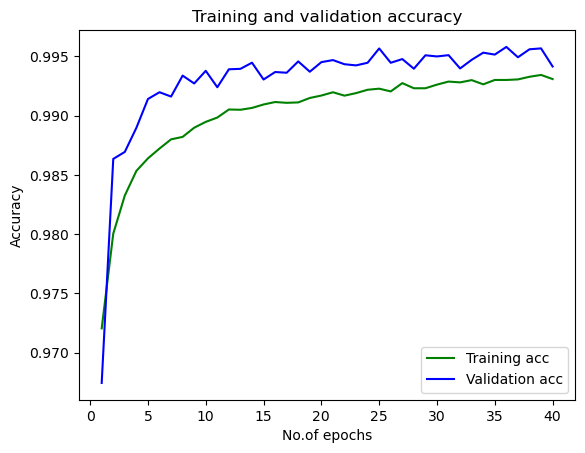

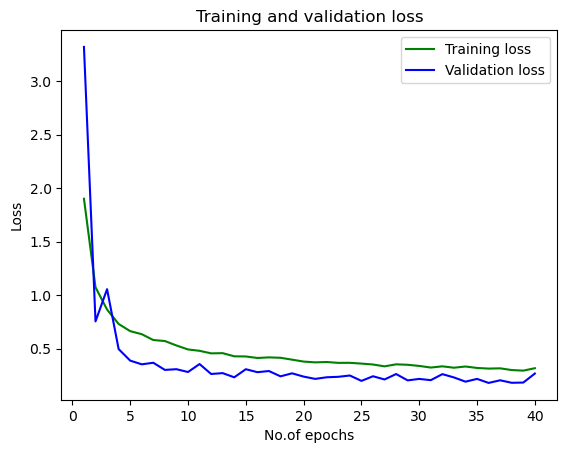

<Figure size 640x480 with 0 Axes>

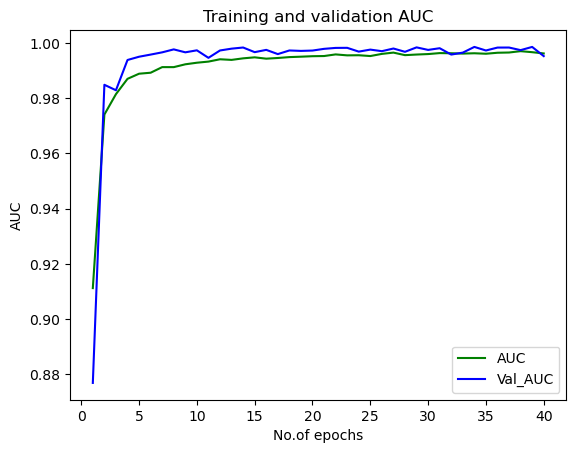

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
AUC = history.history['auc']
val_AUC = history.history['val_auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('No.of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('No.of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No.of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()

In [30]:
print("False Negative Error(Type II): {:.3%}".format((metric_val[8])/(metric_val[8] + metric_val[4])))
print("True Negative Error(Type I): {:.3%}".format((metric_val[6])/(metric_val[6] + metric_val[7])))

False Negative Error(Type II): 12.937%
True Negative Error(Type I): 0.254%


In [31]:
predictions1 = model1.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes1 = np.argmax(predictions1, axis=-1)
predictions1 = np.argmax(predictions1, axis=-1) #multiple categories


68/68 [==============================] - 61s 893ms/step


In [32]:
predictions1

array([14, 26, 19, ..., 27,  8, 20])

In [33]:
from sklearn.metrics import classification_report
true_classes1 = holdout_generator.classes
# true_classes

In [34]:
target_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [35]:
class_labels1 = list(holdout_generator.class_indices.keys())  
# report = metrics.classification_report(true_classes, predicted_classes, target_names=target_names)
print(classification_report(true_classes1, predicted_classes1, target_names=target_names))

              precision    recall  f1-score   support

           A       0.89      0.95      0.92       300
           B       0.76      1.00      0.87       300
           C       1.00      0.99      1.00       300
           D       0.98      0.96      0.97       300
           E       0.73      0.91      0.81       300
           F       1.00      0.95      0.97       300
           G       0.95      0.97      0.96       300
           H       1.00      0.93      0.96       300
           I       0.93      0.92      0.92       300
           J       0.96      0.96      0.96       300
           K       1.00      0.80      0.89       300
           L       1.00      0.93      0.96       300
           M       0.93      0.91      0.92       300
           N       0.98      0.91      0.94       300
           O       0.91      0.98      0.95       300
           P       0.97      0.94      0.95       300
           Q       0.98      0.86      0.92       300
           R       0.76    

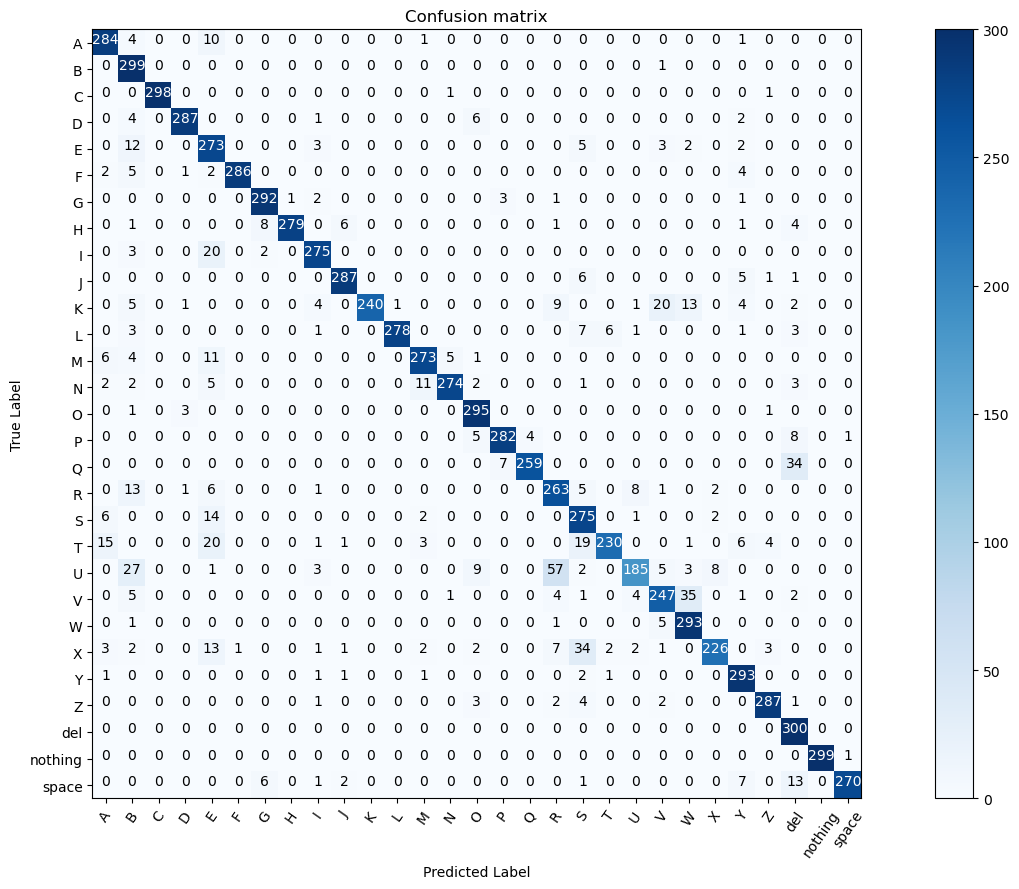

In [36]:
import itertools 
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()


cm = confusion_matrix(true_classes1, predicted_classes1)

cm_plot_label = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')

### MobileNet Model

In [45]:
# Defining the model tf.keras.applications.MobileNetV2
start_time2 = time.time()
def get_model2():
    base_model2 = MobileNetV2(include_top=False, input_shape=(200,200,3))
    
    for layer in base_model2.layers[:150]:
        layer.trainable = False
    for layer in base_model2.layers[150:]:
        layer.trainable = True
    
    x = base_model2.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred2 = Dense(len(classes), activation='softmax')(x)
    
    model2 = Model(inputs=base_model2.input, outputs=pred2)
    
    return model2

In [46]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [47]:

# Initiating the model
model2 = get_model2()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
model2.summary()


9406464/9406464 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 100, 100, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 100, 100, 32  128         ['Conv1[0][0]']                  
                             

In [48]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [49]:
# Training and validating the model
history = model2.fit(train_gen, epochs=80, batch_size=64, validation_data=val_gen,steps_per_epoch=100,validation_steps=50,callbacks=[callback],validation_split = 0.25, 
                    shuffle = True)

Epoch 1/80
100/100 [==============================] - 59s 541ms/step - loss: 2.3387 - tp: 2358.0000 - fp: 1186.0000 - tn: 357214.0000 - fn: 10442.0000 - accuracy: 0.9687 - precision: 0.6653 - recall: 0.1842 - auc: 0.8582 - prc: 0.3535 - val_loss: 2.0406 - val_tp: 1098.0000 - val_fp: 352.0000 - val_tn: 178848.0000 - val_fn: 5302.0000 - val_accuracy: 0.9695 - val_precision: 0.7572 - val_recall: 0.1716 - val_auc: 0.9025 - val_prc: 0.4191
Epoch 2/80
100/100 [==============================] - 50s 503ms/step - loss: 1.7212 - tp: 4129.0000 - fp: 1485.0000 - tn: 356915.0000 - fn: 8671.0000 - accuracy: 0.9726 - precision: 0.7355 - recall: 0.3226 - auc: 0.9307 - prc: 0.5345 - val_loss: 1.8297 - val_tp: 1615.0000 - val_fp: 596.0000 - val_tn: 178604.0000 - val_fn: 4785.0000 - val_accuracy: 0.9710 - val_precision: 0.7304 - val_recall: 0.2523 - val_auc: 0.9232 - val_prc: 0.4799
Epoch 3/80
100/100 [==============================] - 50s 498ms/step - loss: 1.5440 - tp: 4877.0000 - fp: 1571.0000 - tn: 3

In [50]:
training_time2 = time.time() - start_time2
def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   print("seconds value in hours:",hour)
   print("seconds value in minutes:",min)
   return "%02d:%02d:%02d" % (hour, min, sec) 
# n = 1680253639.0539448
print("Time in preferred format :-",convert_to_preferred_format(training_time2))

seconds value in hours: 1.0
seconds value in minutes: 33.0
Time in preferred format :- 01:33:53


In [51]:
model_metrics2 = pd.DataFrame(model2.history.history)
model_metrics2

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
0,2.338709,2358.0,1186.0,357214.0,10442.0,0.968675,0.665350,0.184219,0.858211,0.353544,2.040647,1098.0,352.0,178848.0,5302.0,0.969537,0.757241,0.171562,0.902479,0.419050
1,1.721154,4129.0,1485.0,356915.0,8671.0,0.972640,0.735483,0.322578,0.930710,0.534450,1.829720,1615.0,596.0,178604.0,4785.0,0.971008,0.730439,0.252344,0.923167,0.479893
2,1.543963,4877.0,1571.0,356829.0,7923.0,0.974423,0.756359,0.381016,0.945326,0.593805,1.660208,2075.0,733.0,178467.0,4325.0,0.972748,0.738960,0.324219,0.936887,0.544729
3,1.413446,5483.0,1593.0,354567.0,7237.0,0.976063,0.774873,0.431053,0.953924,0.636587,1.549389,2435.0,824.0,178376.0,3965.0,0.974197,0.747162,0.380469,0.944978,0.588366
4,1.356001,5708.0,1668.0,354492.0,7012.0,0.976469,0.773861,0.448742,0.958733,0.654600,1.399691,2794.0,905.0,178295.0,3606.0,0.975695,0.755339,0.436563,0.953418,0.640944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.670868,9189.0,1503.0,356897.0,3611.0,0.986223,0.859428,0.717891,0.987938,0.874439,0.832031,4679.0,1059.0,178141.0,1721.0,0.985022,0.815441,0.731094,0.975991,0.848802
76,0.664376,9303.0,1494.0,356906.0,3497.0,0.986554,0.861628,0.726797,0.988208,0.876803,0.785942,4684.0,1018.0,178182.0,1716.0,0.985269,0.821466,0.731875,0.979513,0.854476
77,0.641458,9453.0,1411.0,356989.0,3347.0,0.987182,0.870121,0.738516,0.988817,0.883516,0.811948,4693.0,1053.0,178147.0,1707.0,0.985129,0.816742,0.733281,0.975829,0.851906
78,0.654120,9321.0,1454.0,354706.0,3399.0,0.986844,0.865058,0.732783,0.988263,0.878699,0.800569,4603.0,1130.0,178070.0,1797.0,0.984230,0.802896,0.719219,0.979521,0.849355


In [52]:
history.history['loss']

[2.3387086391448975,
 1.7211536169052124,
 1.543962836265564,
 1.4134457111358643,
 1.3560009002685547,
 1.2662780284881592,
 1.2405054569244385,
 1.197744607925415,
 1.1247185468673706,
 1.1187620162963867,
 1.099710464477539,
 1.0503958463668823,
 1.0469508171081543,
 1.0221692323684692,
 0.9956158399581909,
 0.9961608052253723,
 0.9570598602294922,
 0.9478452801704407,
 0.9477725028991699,
 0.9118982553482056,
 0.9502342343330383,
 0.924297571182251,
 0.8914122581481934,
 0.8873058557510376,
 0.875266969203949,
 0.8747970461845398,
 0.8538908958435059,
 0.8372575640678406,
 0.8442020416259766,
 0.8205094337463379,
 0.8314459919929504,
 0.8193389177322388,
 0.819612979888916,
 0.8226079344749451,
 0.8047784566879272,
 0.7938726544380188,
 0.7837730050086975,
 0.7683497667312622,
 0.7892869114875793,
 0.7593839764595032,
 0.7684216499328613,
 0.774252712726593,
 0.7639324069023132,
 0.7572505474090576,
 0.7633811831474304,
 0.7486141920089722,
 0.748490571975708,
 0.7431471347808838,


In [53]:
history.history['accuracy']

[0.9686745405197144,
 0.9726400971412659,
 0.9744234681129456,
 0.9760626554489136,
 0.9764693379402161,
 0.9775862097740173,
 0.9781249761581421,
 0.9785776138305664,
 0.9794180989265442,
 0.9794638752937317,
 0.979966402053833,
 0.9805279970169067,
 0.9804013967514038,
 0.9809859991073608,
 0.9811422228813171,
 0.9815706014633179,
 0.9821188449859619,
 0.982101321220398,
 0.9819100499153137,
 0.9823545217514038,
 0.9820754528045654,
 0.9823626279830933,
 0.9830334186553955,
 0.9829444885253906,
 0.9829983711242676,
 0.983184278011322,
 0.9833863377571106,
 0.9834617376327515,
 0.9834994673728943,
 0.9841756224632263,
 0.9837042093276978,
 0.9841002225875854,
 0.9837068915367126,
 0.9839351773262024,
 0.9843184351921082,
 0.9844019412994385,
 0.9842388033866882,
 0.9849436283111572,
 0.9843607544898987,
 0.9850296378135681,
 0.984803318977356,
 0.9845993518829346,
 0.9847440719604492,
 0.9852128028869629,
 0.9851387739181519,
 0.9852505326271057,
 0.9852336645126343,
 0.98516702651977

In [54]:
metrics = ['auc', 'prc', 'precision', 'recall','tp','accuracy','fp','tn','fn']
metric_val = [history.history[f][-1] for f in metrics]
print('Accuracy: {:.3%}'.format(metric_val[5]))
print('Precision-Recall: {:.3%}'.format(metric_val[1]))
print('Recall: {:.3%}'.format(metric_val[3]))
print('Precision: {:.3%}'.format(metric_val[2]))
print('True Positive: {}'.format(metric_val[4]))
print('True Negative: {}'.format(metric_val[7]))
print('False Positive: {}'.format(metric_val[6]))
print('False Negative: {}'.format(metric_val[8]))

Accuracy: 98.718%
Precision-Recall: 88.574%
Recall: 74.016%
Precision: 86.862%
True Positive: 9474.0
True Negative: 356967.0
False Positive: 1433.0
False Negative: 3326.0


In [55]:
model2.save('/kaggle/working/model_mob.h5') #correct

In [92]:
#load model
from tensorflow.keras.models import load_model
model2 = load_model('/kaggle/working/model_mob.h5')


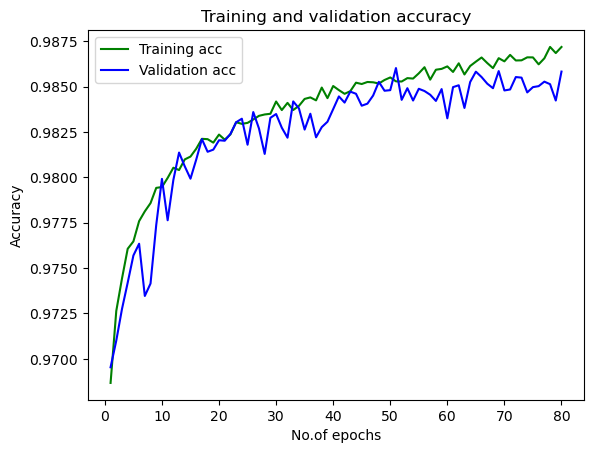

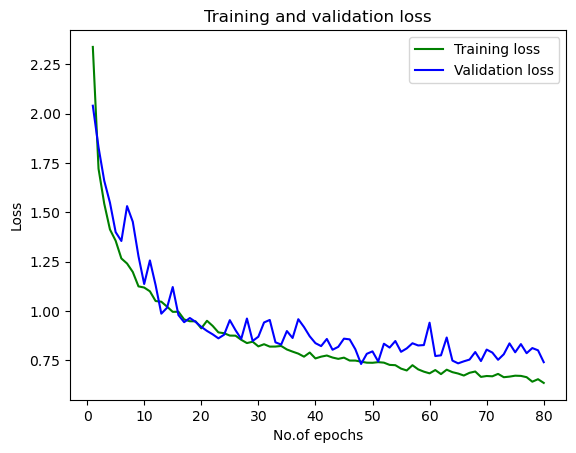

<Figure size 640x480 with 0 Axes>

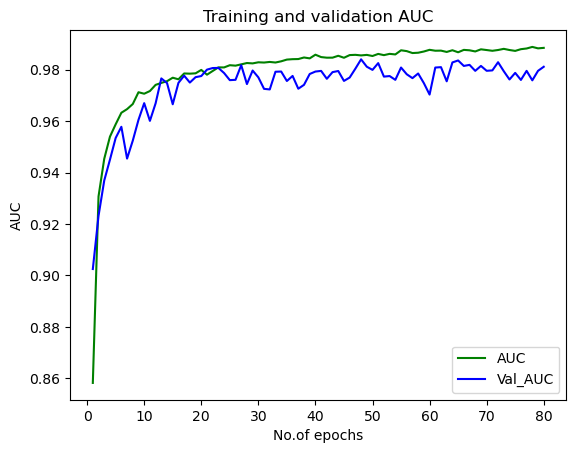

<Figure size 640x480 with 0 Axes>

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
AUC = history.history['auc']
val_AUC = history.history['val_auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('No.of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('No.of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No.of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()

In [58]:
print("False Negative Error(Type II): {:.3%}".format((metric_val[8])/(metric_val[8] + metric_val[4])))
print("True Negative Error(Type I): {:.3%}".format((metric_val[6])/(metric_val[6] + metric_val[7])))

False Negative Error(Type II): 25.984%
True Negative Error(Type I): 0.400%


In [59]:
predictions2 = model2.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes2 = np.argmax(predictions2, axis=-1)
predictions2 = np.argmax(predictions2, axis=-1) #multiple categories

68/68 [==============================] - 21s 304ms/step


In [60]:
predictions2

array([14, 26, 18, ..., 27,  8, 23])

In [61]:
from sklearn.metrics import classification_report
true_classes2 = holdout_generator.classes
# true_classes

In [62]:
target_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [63]:
class_labels2 = list(holdout_generator.class_indices.keys())  
# report = metrics.classification_report(true_classes, predicted_classes, target_names=target_names)
print(classification_report(true_classes2, predicted_classes2, target_names=target_names))

              precision    recall  f1-score   support

           A       0.86      0.74      0.79       300
           B       0.85      0.78      0.81       300
           C       0.93      0.96      0.94       300
           D       0.76      0.93      0.83       300
           E       0.75      0.81      0.78       300
           F       0.93      0.92      0.93       300
           G       0.84      0.81      0.83       300
           H       0.91      0.84      0.87       300
           I       0.55      0.78      0.64       300
           J       0.80      0.83      0.82       300
           K       0.71      0.87      0.78       300
           L       0.89      0.80      0.84       300
           M       0.88      0.70      0.78       300
           N       0.89      0.77      0.83       300
           O       0.93      0.88      0.90       300
           P       0.76      0.90      0.82       300
           Q       0.75      0.90      0.82       300
           R       0.59    

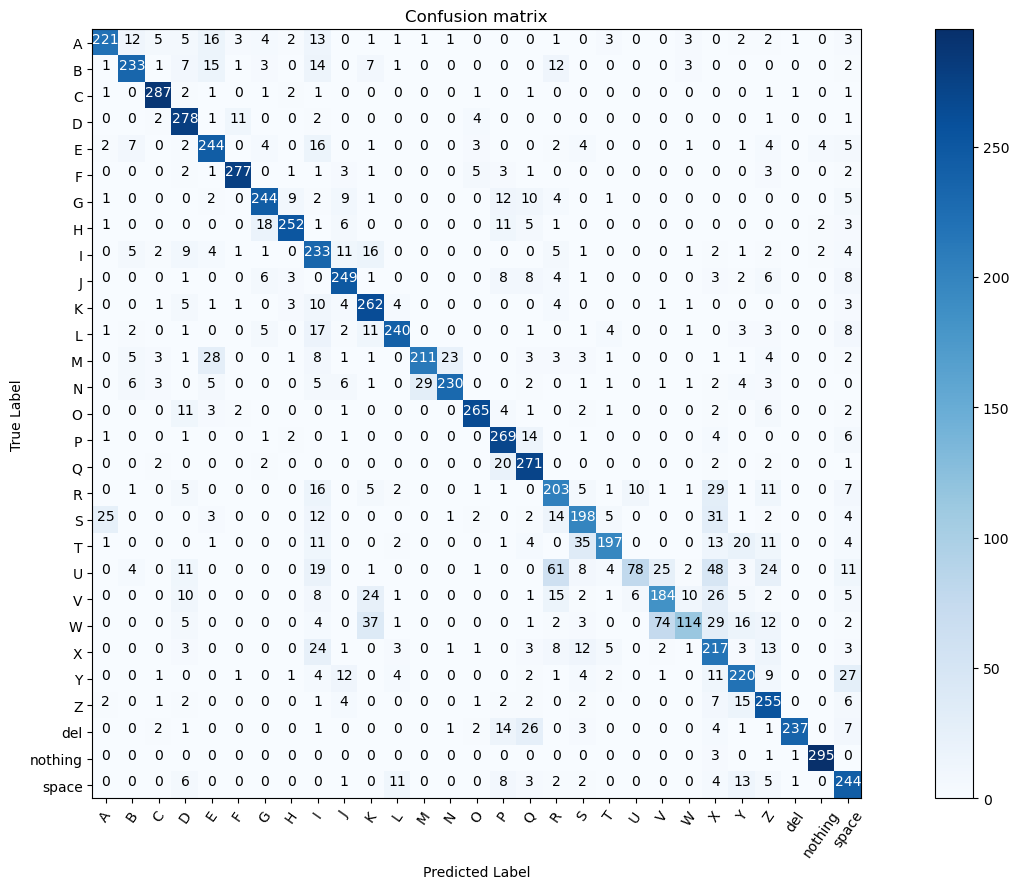

In [64]:
import itertools 
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()


cm = confusion_matrix(true_classes2, predicted_classes2)

cm_plot_label = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')

#### VGG16 Model

In [93]:
# Defining the model
from keras.applications.vgg19 import VGG19
import time
start_time3 = time.time()
def get_model3():
    base_model3 = VGG19(include_top=False, input_shape=(200,200,3))
    
    for layer in base_model3.layers[:170]:
        layer.trainable = False
    for layer in base_model3.layers[170:]:
        layer.trainable = True
    
    x = base_model3.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1000, activation='relu')(x)
    pred3 = Dense(len(classes), activation='softmax')(x)
    
    model3 = Model(inputs=base_model3.input, outputs=pred3)
    
    return model3

In [94]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [95]:
# Initiating the model
model3 = get_model3()
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
model3.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

In [96]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

In [97]:
# Training and validating the model
history = model3.fit(train_gen, epochs=80, batch_size=100, validation_data=val_gen,steps_per_epoch=100,validation_steps=50,callbacks=[callback],validation_split = 0.25, 
                    shuffle = True)

Epoch 1/80
100/100 [==============================] - 50s 482ms/step - loss: 2.8945 - tp: 242.0000 - fp: 27.0000 - tn: 358373.0000 - fn: 12558.0000 - accuracy: 0.9661 - precision: 0.8996 - recall: 0.0189 - auc: 0.7529 - prc: 0.1797 - val_loss: 2.5059 - val_tp: 322.0000 - val_fp: 35.0000 - val_tn: 179165.0000 - val_fn: 6078.0000 - val_accuracy: 0.9671 - val_precision: 0.9020 - val_recall: 0.0503 - val_auc: 0.8427 - val_prc: 0.2984
Epoch 2/80
100/100 [==============================] - 46s 459ms/step - loss: 2.3664 - tp: 1113.0000 - fp: 158.0000 - tn: 358242.0000 - fn: 11687.0000 - accuracy: 0.9681 - precision: 0.8757 - recall: 0.0870 - auc: 0.8633 - prc: 0.3331 - val_loss: 2.3687 - val_tp: 748.0000 - val_fp: 149.0000 - val_tn: 179051.0000 - val_fn: 5652.0000 - val_accuracy: 0.9687 - val_precision: 0.8339 - val_recall: 0.1169 - val_auc: 0.8625 - val_prc: 0.3220
Epoch 3/80
100/100 [==============================] - 56s 559ms/step - loss: 2.1345 - tp: 1688.0000 - fp: 285.0000 - tn: 358115.0

In [98]:
training_time3 = time.time() - start_time3

def convert_to_preferred_format(sec):
   sec = sec % (24 * 3600)
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   print("seconds value in hours:",hour)
   print("seconds value in minutes:",min)
   return "%02d:%02d:%02d" % (hour, min, sec) 

# n = 1680253639.0539448
print("Time in preferred format :-",convert_to_preferred_format(training_time3))

seconds value in hours: 1.0
seconds value in minutes: 31.0
Time in preferred format :- 01:31:42


In [99]:
model_metrics3 = pd.DataFrame(model3.history.history)
model_metrics3

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
0,2.894481,242.0,27.0,358373.0,12558.0,0.966096,0.899628,0.018906,0.752876,0.179694,2.505863,322.0,35.0,179165.0,6078.0,0.967064,0.901961,0.050313,0.842676,0.298358
1,2.366368,1113.0,158.0,358242.0,11687.0,0.968090,0.875688,0.086953,0.863300,0.333074,2.368694,748.0,149.0,179051.0,5652.0,0.968745,0.833891,0.116875,0.862473,0.321952
2,2.134480,1688.0,285.0,358115.0,11112.0,0.969297,0.855550,0.131875,0.893328,0.405930,2.178474,953.0,496.0,178704.0,5447.0,0.967980,0.657695,0.148906,0.890856,0.346365
3,2.025930,2072.0,383.0,358017.0,10728.0,0.970067,0.843992,0.161875,0.904688,0.437540,2.150601,1136.0,493.0,178707.0,5264.0,0.968982,0.697360,0.177500,0.892985,0.374379
4,1.932170,2368.0,425.0,357975.0,10432.0,0.970752,0.847834,0.185000,0.915334,0.464892,2.010972,1351.0,498.0,178702.0,5049.0,0.970113,0.730665,0.211094,0.907381,0.423954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.981933,7228.0,1192.0,357208.0,5572.0,0.981778,0.858432,0.564687,0.978766,0.784356,1.204598,3504.0,991.0,178209.0,2896.0,0.979057,0.779533,0.547500,0.963042,0.719592
76,0.985797,7273.0,1264.0,357136.0,5527.0,0.981705,0.851939,0.568203,0.978505,0.782998,1.158135,3487.0,1003.0,178197.0,2913.0,0.978901,0.776615,0.544844,0.967737,0.726595
77,0.975117,7277.0,1231.0,357169.0,5523.0,0.981805,0.855313,0.568516,0.978510,0.786443,1.121306,3619.0,1005.0,178195.0,2781.0,0.979601,0.782656,0.565469,0.969869,0.737742
78,0.980705,7319.0,1238.0,357162.0,5481.0,0.981899,0.855323,0.571797,0.978131,0.786293,1.095194,3625.0,969.0,178231.0,2775.0,0.979828,0.789073,0.566406,0.972248,0.742315


In [100]:
history.history['loss']

[2.8944807052612305,
 2.366368055343628,
 2.1344802379608154,
 2.0259299278259277,
 1.9321703910827637,
 1.856290578842163,
 1.8074275255203247,
 1.7555562257766724,
 1.7324720621109009,
 1.679397463798523,
 1.658748984336853,
 1.6182583570480347,
 1.5968095064163208,
 1.5740922689437866,
 1.5308870077133179,
 1.5364232063293457,
 1.537710428237915,
 1.4946999549865723,
 1.4655555486679077,
 1.4434624910354614,
 1.4457603693008423,
 1.4018882513046265,
 1.3990113735198975,
 1.3925449848175049,
 1.351574420928955,
 1.3591307401657104,
 1.349297046661377,
 1.338257908821106,
 1.3034096956253052,
 1.2916122674942017,
 1.296059012413025,
 1.2857125997543335,
 1.2637883424758911,
 1.247705101966858,
 1.234161138534546,
 1.2335342168807983,
 1.2289637327194214,
 1.2037792205810547,
 1.2294021844863892,
 1.191820740699768,
 1.1807315349578857,
 1.175500512123108,
 1.1797465085983276,
 1.1748710870742798,
 1.1381548643112183,
 1.1247442960739136,
 1.1400642395019531,
 1.1361445188522339,
 1.10

In [101]:
history.history['accuracy']

[0.9660964608192444,
 0.9680899977684021,
 0.9692968726158142,
 0.9700673222541809,
 0.9707516431808472,
 0.9715355634689331,
 0.9717089533805847,
 0.9723680019378662,
 0.9724649786949158,
 0.9729606509208679,
 0.9731627106666565,
 0.9734132289886475,
 0.9739251136779785,
 0.9739035367965698,
 0.9743857979774475,
 0.9744908213615417,
 0.9745635986328125,
 0.9750646352767944,
 0.9753957986831665,
 0.9755765199661255,
 0.9755953550338745,
 0.9761044979095459,
 0.976155698299408,
 0.9763907194137573,
 0.976883053779602,
 0.9765194058418274,
 0.9767672419548035,
 0.9769935607910156,
 0.9772690534591675,
 0.9776212573051453,
 0.9775265455245972,
 0.9774272441864014,
 0.9777154922485352,
 0.9783216714859009,
 0.9782004356384277,
 0.9784805774688721,
 0.9785802960395813,
 0.9785802960395813,
 0.9782300591468811,
 0.9785974025726318,
 0.9786476492881775,
 0.9788577556610107,
 0.9789091348648071,
 0.9792349338531494,
 0.9796248078346252,
 0.9798226952552795,
 0.9795878529548645,
 0.979609370231

In [102]:
metrics = ['auc', 'prc', 'precision', 'recall','tp','accuracy','fp','tn','fn']
metric_val = [history.history[f][-1] for f in metrics]
print('Accuracy: {:.3%}'.format(metric_val[5]))
print('Precision-Recall: {:.3%}'.format(metric_val[1]))
print('Recall: {:.3%}'.format(metric_val[3]))
print('Precision: {:.3%}'.format(metric_val[2]))
print('True Positive: {}'.format(metric_val[4]))
print('True Negative: {}'.format(metric_val[7]))
print('False Positive: {}'.format(metric_val[6]))
print('False Negative: {}'.format(metric_val[8]))

Accuracy: 98.190%
Precision-Recall: 78.755%
Recall: 56.922%
Precision: 85.809%
True Positive: 7286.0
True Negative: 357195.0
False Positive: 1205.0
False Negative: 5514.0


In [103]:
model3.save('/kaggle/working/model_vgg.h5') #correct

In [115]:
#load model
from tensorflow.keras.models import load_model
model3 = load_model('/kaggle/working/model_vgg.h5')

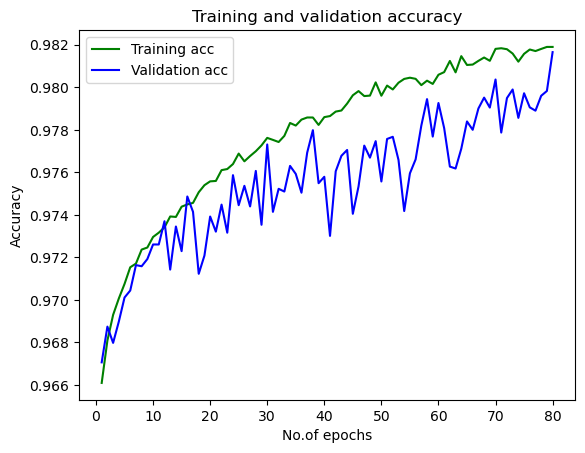

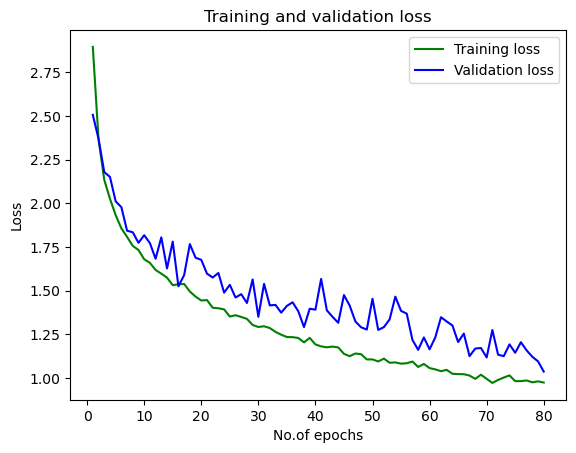

<Figure size 640x480 with 0 Axes>

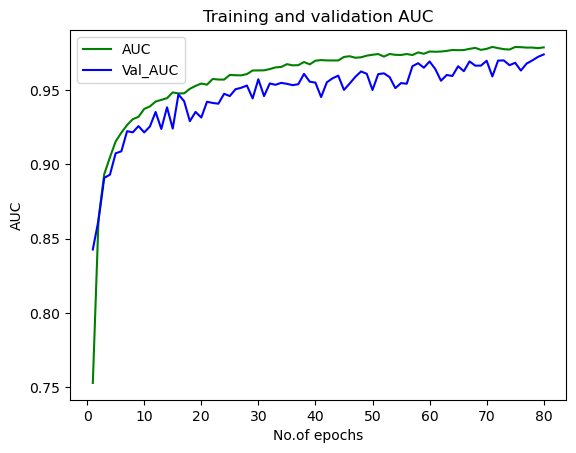

<Figure size 640x480 with 0 Axes>

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
AUC = history.history['auc']
val_AUC = history.history['val_auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('No.of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('No.of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No.of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()

In [105]:
print("False Negative Error(Type II): {:.3%}".format((metric_val[8])/(metric_val[8] + metric_val[4])))
print("True Negative Error(Type I): {:.3%}".format((metric_val[6])/(metric_val[6] + metric_val[7])))

False Negative Error(Type II): 43.078%
True Negative Error(Type I): 0.336%


In [106]:
predictions3 = model3.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes3 = np.argmax(predictions3, axis=-1)
predictions3 = np.argmax(predictions3, axis=-1) #multiple categories

68/68 [==============================] - 24s 359ms/step


In [107]:
from sklearn.metrics import classification_report
true_classes3 = holdout_generator.classes
# true_classes

In [108]:
target_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [109]:
class_labels3 = list(holdout_generator.class_indices.keys())  
# report = metrics.classification_report(true_classes, predicted_classes, target_names=target_names)
print(classification_report(true_classes3, predicted_classes3, target_names=target_names))

              precision    recall  f1-score   support

           A       0.52      0.79      0.63       300
           B       0.69      0.69      0.69       300
           C       0.94      0.92      0.93       300
           D       0.61      0.94      0.74       300
           E       0.83      0.66      0.74       300
           F       0.93      0.88      0.90       300
           G       0.83      0.56      0.67       300
           H       0.96      0.57      0.71       300
           I       0.60      0.71      0.65       300
           J       0.82      0.63      0.71       300
           K       0.82      0.60      0.69       300
           L       0.42      0.98      0.59       300
           M       0.51      0.66      0.58       300
           N       0.76      0.80      0.78       300
           O       0.56      0.84      0.67       300
           P       0.94      0.79      0.86       300
           Q       0.96      0.82      0.89       300
           R       0.54    

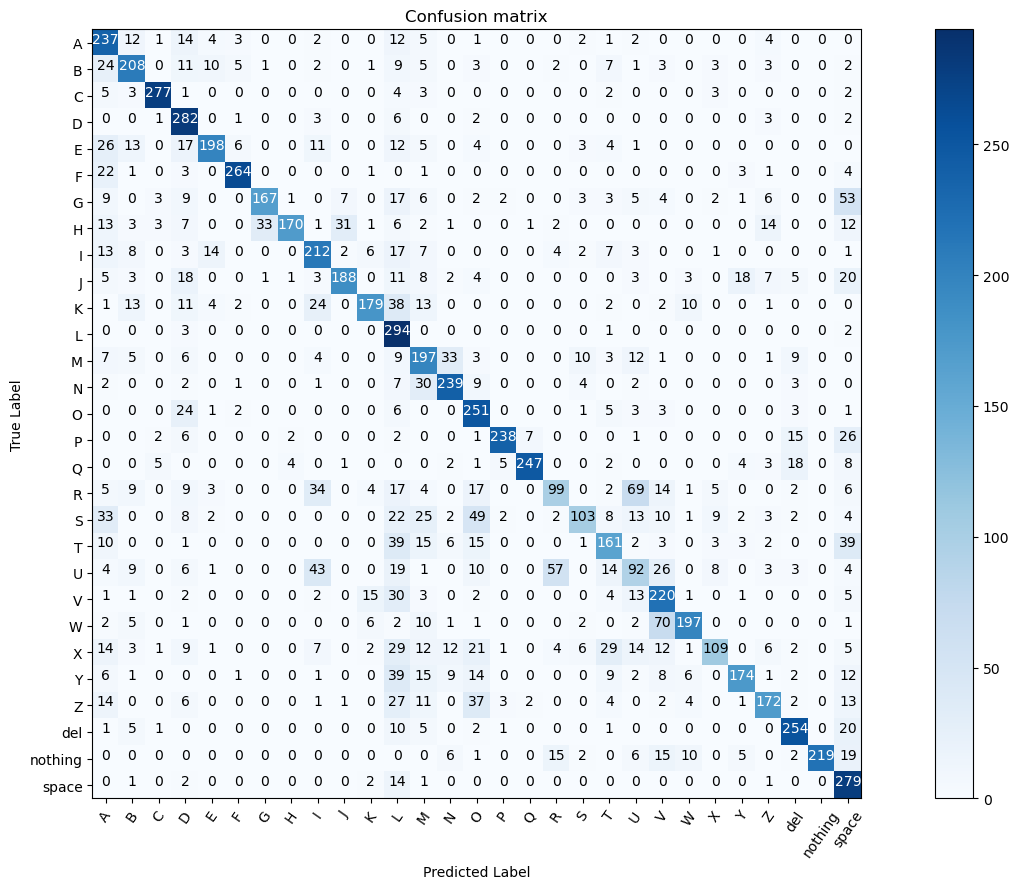

In [110]:
import itertools 
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()


cm = confusion_matrix(true_classes3, predicted_classes3)

cm_plot_label = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')

### Ensemble Learning Model

In [116]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [117]:
from sklearn.metrics import confusion_matrix,classification_report
# Predict using each model
resnet_preds = model1.predict(holdout_generator,verbose=True)
mobilenet_preds = model2.predict(holdout_generator,verbose=True)
vgg_preds=model3.predict(holdout_generator,verbose=True)
# inception_preds = inception_model.predict(x_test)

# Ensembling using Maximum horizontal voting
ensemble_preds = np.maximum.reduce([resnet_preds, mobilenet_preds,vgg_preds])
ensemble_preds = np.argmax(ensemble_preds,axis=1)

68/68 [==============================] - 15s 213ms/step


In [118]:
pred_en=ensemble_preds

In [119]:
pred_en

array([14, 26, 19, ..., 27,  8, 20])

In [120]:
labels=holdout_generator.classes

In [121]:
# labels

In [122]:
target_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','nothing','del','space']
print('Confusion Matrix')
print(confusion_matrix(holdout_generator.classes, pred_en))
print('Classification Report')

Confusion Matrix
[[284   3   2   0   4   2   0   0   0   0   0   2   2   1   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0 298   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   1]
 [  0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 300   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0]
 [  3   8   0   2 269   0   0   0   2   0   0   4   0   0   2   0   0   1
    3   0   0   0   1   0   1   4   0   0   0]
 [  0   0   0   1   0 293   0   0   0   1   0   0   0   0   0   1   0   0
    0   0   0   0   0   0   3   0   0   0   1]
 [  0   0   0   0   0   0 283   3   2   0   0   3   0   0   0   3   3   0
    0   1   0   0   0   0   0   0   0   0   2]
 [  0   0   0   0   0   0   9 280   0   4   0   0   0   0   0   1   0   1
    0   0   0   0   0   0   1   0   3   0   1]
 [  0   3   0  

              precision    recall  f1-score   support

           A       0.90      0.95      0.92       300
           B       0.85      0.99      0.91       300
           C       0.99      1.00      0.99       300
           D       0.92      1.00      0.96       300
           E       0.83      0.90      0.86       300
           F       0.99      0.98      0.98       300
           G       0.97      0.94      0.95       300
           H       0.99      0.93      0.96       300
           I       0.92      0.95      0.94       300
           J       0.96      0.99      0.98       300
           K       0.97      0.92      0.94       300
           L       0.85      1.00      0.92       300
           M       0.94      0.90      0.92       300
           N       0.98      0.93      0.96       300
           O       0.95      0.98      0.97       300
           P       0.98      0.97      0.97       300
           Q       0.98      0.97      0.97       300
           R       0.80    

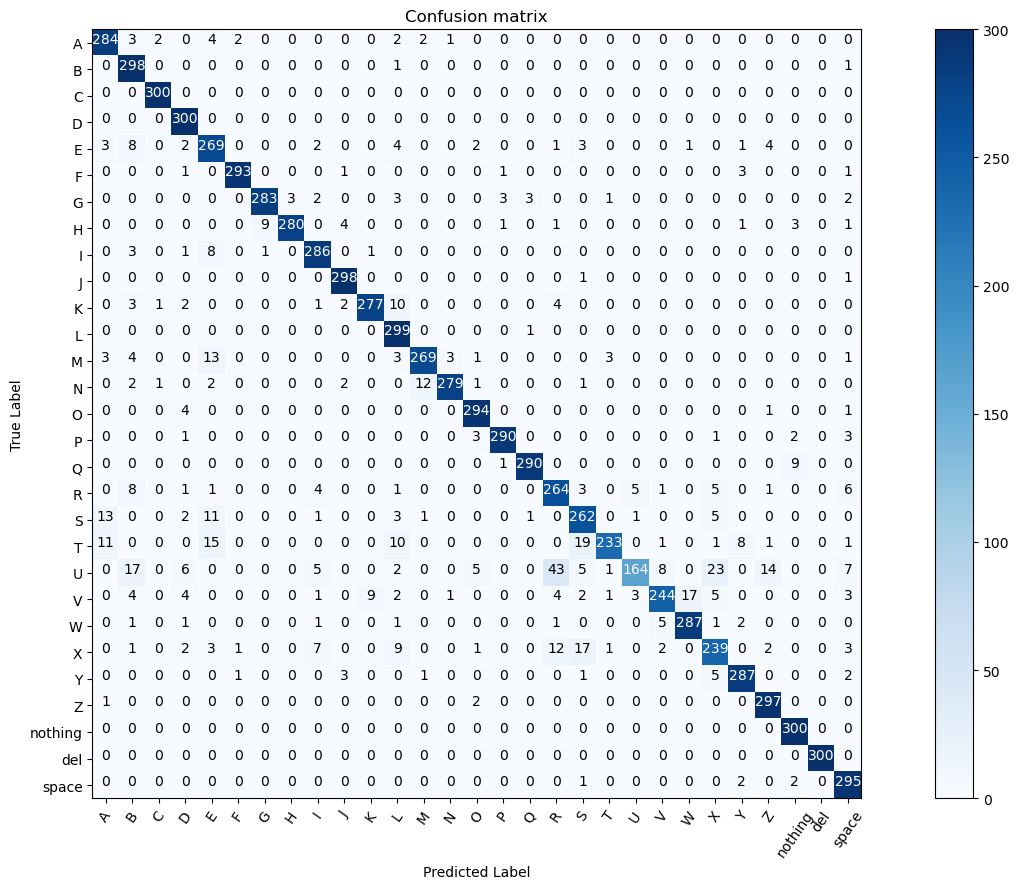

In [123]:
# Classification Report RMSprop
from sklearn.metrics import classification_report

print(classification_report(holdout_generator.classes, pred_en, target_names=target_names))

def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(15, 9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()


cm = confusion_matrix(holdout_generator.classes, pred_en)

cm_plot_label = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','nothing','del','space']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion matrix')